In [1]:
import glob 
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Laplace
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

import poisevae
from poisevae.datasets import CUB
from poisevae.utils import NN_lookup, Categorical
from poisevae.networks.CUBNetworks import EncImg, DecImg, EncTxt, DecTxt

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['text.usetex'] = False

In [2]:
HOME_PATH = os.path.expanduser('~')
DATA_PATH = os.path.join(HOME_PATH, 'Datasets/CUB/')

In [3]:
tx = lambda data: torch.Tensor(data)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
CUB_train = CUB(DATA_PATH, DATA_PATH, 'train', device, tx, return_idx=False)
CUB_test = CUB(DATA_PATH, DATA_PATH, 'test', device, tx, return_idx=True)

In [6]:
vocab_size, txt_len = CUB_train.CUBtxt.vocab_size, CUB_train.CUBtxt.max_sequence_length
vocab_size, txt_len

(1590, 32)

In [7]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(CUB_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(CUB_test, batch_size=batch_size, shuffle=True, drop_last=True)
len(train_loader), len(test_loader)

(691, 229)

In [8]:
enc_img = EncImg(128).to(device)
dec_img = DecImg(128).to(device)
enc_txt = EncTxt(vocab_size, 128).to(device)
dec_txt = DecTxt(vocab_size, 128).to(device)
    
rec_weights = [1, 2048/txt_len]
vae = poisevae.POISEVAE([enc_img, enc_txt], [dec_img, dec_txt], likelihoods=[Laplace, Categorical], 
                        latent_dims=[128, (128, 1, 1)], rec_weights=rec_weights, fix_t=True).to(device)

In [9]:
# for i in vae.named_parameters():
#     print(i[0])

In [10]:
optimizer = optim.Adam(vae.parameters(), lr=5e-4, amsgrad=True)

In [11]:
from datetime import datetime
PATH = os.path.join('runs/CUB', datetime.now().strftime('%y%m%d%H%M'))
if os.path.exists(PATH):
        raise ValueError

In [12]:
epoch = 0
# try:
#     vae, optimizer, epoch = poisevae.utils.load_checkpoint(vae, optimizer, sorted(glob.glob(PATH + 'train*.pt'))[-1])
# except:
#     pass

In [13]:
writer = SummaryWriter(PATH)
# writer = None

In [ ]:
epochs = 50 + epoch
for epoch in tqdm(range(epoch, epochs)):
    poisevae.utils.train(vae, train_loader, optimizer, epoch, writer)
    labels, latent_info = poisevae.utils.test(vae, test_loader, epoch, writer, 
                                              record_idx=(-1,), return_latents=True)
    if (epoch+1) % 10 == 0 and epoch > 0:
        poisevae.utils.save_checkpoint(vae, optimizer, os.path.join(PATH, 'training_%d.pt' % (epoch+1)), epoch+1)

In [ ]:
writer.flush()
writer.close()

In [16]:
# poisevae.utils.save_latent_info(latent_info, PATH)

## Results

In [9]:
PATH = 'runs/CUB/worew/2201232127/'
# PATH = 'runs/CUB/wrew/2201232212/'
# vae, _, epoch = poisevae.utils.load_checkpoint(vae, load_path=sorted(glob.glob(os.path.join(PATH, 'train*.pt')))[-1])
vae, _, epoch = poisevae.utils.load_checkpoint(vae, load_path=os.path.join(PATH, 'training_50.pt'))
epoch

50

### Reconstruction

In [36]:
with torch.no_grad():
    for i, (img, txt, idx) in enumerate(test_loader):
        results = vae([img.to(device), txt.to(device)])
        x_rec = results['x_rec']
        x_rec = [x_rec[0].loc, x_rec[1].probs.argmax(dim=1).reshape(x_rec[0].loc.shape[0], -1)]
        dist, idx_h = NN_lookup(x_rec[0], img)
        # dist, idx_h = NN_lookup(results['x_rec'][0], img)
        imgs_h = [CUB_test.CUBimg.dataset[int(idx[j]) // 10][0] for j in idx_h]
        imgs = [CUB_test.CUBimg.dataset[int(j) // 10][0] for j in idx]
        txts = [CUB_test.CUBtxt.data[str(int(j))] for j in idx]
        break

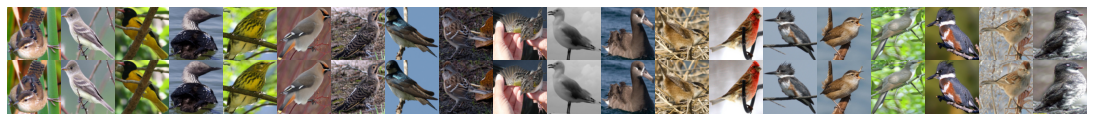

In [37]:
ncols = min(len(imgs_h), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(imgs, imgs_h)):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.permute(1, 2, 0))
        # ax[j, i].set_xticks([])
        # ax[j, i].set_yticks([])
        ax[j, i].set_axis_off()
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
fig.savefig(os.path.join(PATH, 'CUBImgRec.pdf'), dpi=300)

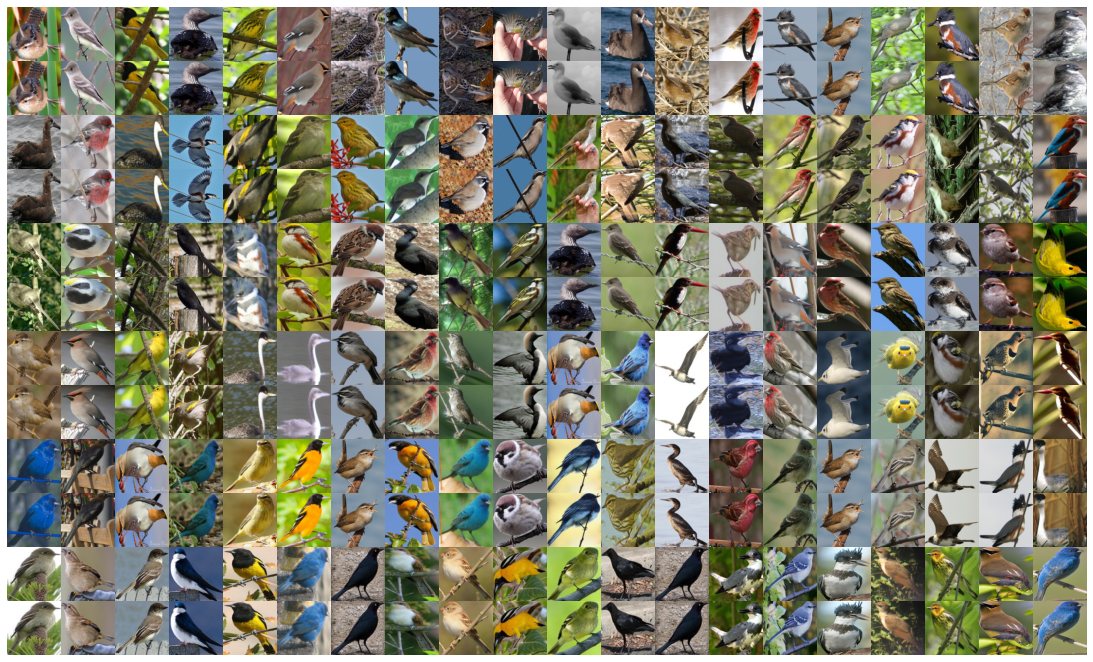

In [38]:
ncols = min(len(imgs_h), 20)
nrows = 2 * int(np.floor(len(imgs_h) / 20))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 1.5*nrows/2))
for i, aux in enumerate(zip(imgs, imgs_h)):
    if i >= nrows / 2 * 20:
        break
    for j, im in enumerate(aux):
        ax[j+i//20*2, i%20].imshow(im.permute(1, 2, 0))
        # ax[j+i//20*2, i%20].set_xticks([])
        # ax[j+i//20*2, i%20].set_yticks([])
        ax[j+i//20*2, i%20].set_axis_off()
    ax[1+i//20*2, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
fig.savefig(os.path.join(PATH, 'CUBImgRecExtra.pdf'), dpi=300)

In [39]:
sents_h = []
sents_emb = x_rec[1]
for sent_emb in sents_emb:
    sent_h = []
    for j in sent_emb:
        char = CUB_test.CUBtxt.i2w[str(int(j.item()))]
        if char == '<eos>':
            break
        sent_h.append(char)
    sents_h.append(' '.join(sent_h))

sents = []
for i, sent_h in enumerate(sents_h):
    sent = []
    for char in txts[i]['tok']:
        if char == '<eos>':
            break
        sent.append(char)
    sents.append(' '.join(sent))

In [40]:
for sent, sent_h in zip(sents, sents_h):
    print('     ', sent)
    print('Rec: ', sent_h)

      this bird has a cream colored breast , throat and side , along with a brown and black stripes on its brown rectrices .
Rec:  this bird has a light pointed bill , a , brown and and a , and and brown , and and and wings .
      a small white and gray bird and a short pointed beak .
Rec:  a small brown and white bird with a small pointed beak .
      a bird with yellow belly , breast and rectrices , the short pink bill and pointed and black crown .
Rec:  this bird has yellow yellow , a black belly , a black yellow , and and and and wings .
      this bird is black and white in color with a sharp black beak , and grey eye rings .
Rec:  this bird is white and brown in color with a flat flat beak , and black eye rings .
      this bird has a yellow breast and head with black stripes , small pointed bill and black eyering .
Rec:  this bird has a white and and breast , black wings and a a and and black bill .
      the bird has a brown crown with black eye brow and eye ring .
Rec:  this 

In [41]:
with open(os.path.join(PATH, 'CUBTxtRec.txt'), 'w') as file:
    for sent, sent_h in zip(sents, sents_h):
        file.write('Ref: ' + sent + '\n')
        file.write('Rec: ' + sent_h + '\n')

### Cross Generation

#### Image -> Caption

In [42]:
with torch.no_grad():
    for i, (img, txt, idx) in enumerate(test_loader):
        results = vae([img.to(device), None])
        x_rec = results['x_rec']
        x_rec = [x_rec[0].loc, x_rec[1].probs.argmax(dim=1).reshape(x_rec[0].loc.shape[0], -1)]
        dist, idx_h = NN_lookup(x_rec[0], img)
        # dist, idx_h = NN_lookup(results['x_rec'][0], img)
        imgs_h = [CUB_test.CUBimg.dataset[int(idx[j]) // 10][0] for j in idx_h]
        imgs = [CUB_test.CUBimg.dataset[int(j) // 10][0] for j in idx]
        txts = [CUB_test.CUBtxt.data[str(int(j))] for j in idx]
        break

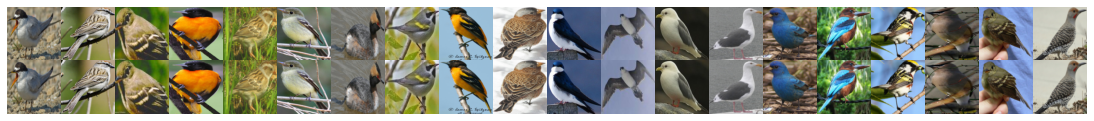

In [43]:
ncols = min(len(imgs_h), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(imgs, imgs_h)):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.permute(1, 2, 0))
        # ax[j, i].set_xticks([])
        # ax[j, i].set_yticks([])
        ax[j, i].set_axis_off()
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
fig.savefig(os.path.join(PATH, 'CUBImgX_Img2Txt.pdf'), dpi=300)

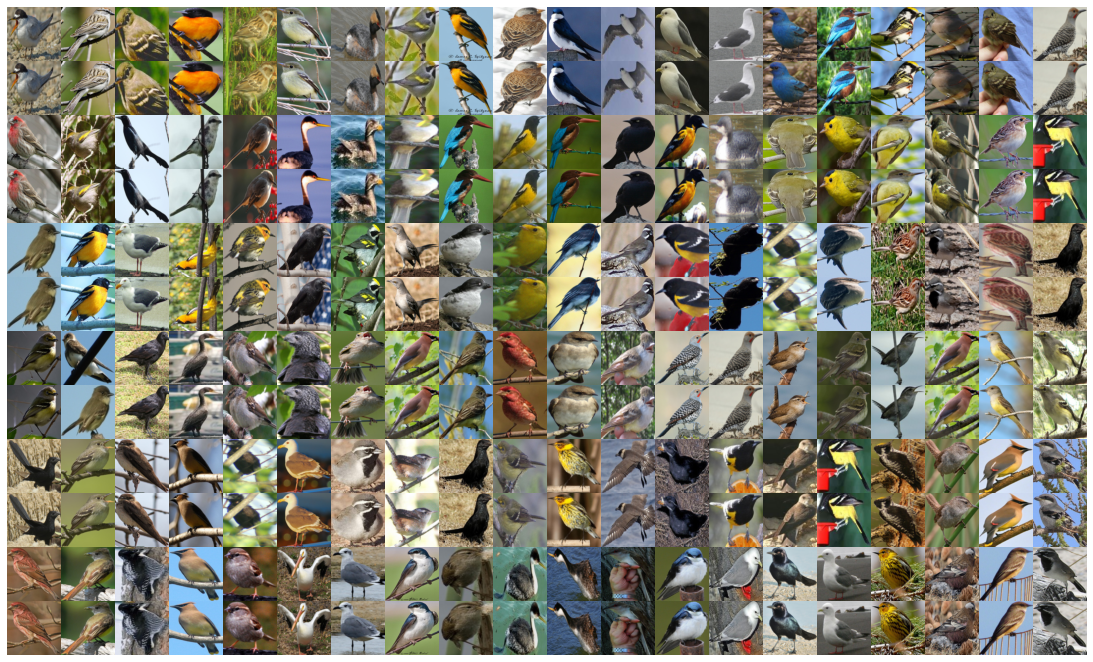

In [44]:
ncols = min(len(imgs_h), 20)
nrows = 2 * int(np.floor(len(imgs_h) / 20))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 1.5*nrows/2))
for i, aux in enumerate(zip(imgs, imgs_h)):
    if i >= nrows / 2 * 20:
        break
    for j, im in enumerate(aux):
        ax[j+i//20*2, i%20].imshow(im.permute(1, 2, 0))
        # ax[j+i//20*2, i%20].set_xticks([])
        # ax[j+i//20*2, i%20].set_yticks([])
        ax[j+i//20*2, i%20].set_axis_off()
    ax[1+i//20*2, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
fig.savefig(os.path.join(PATH, 'CUBImgX_Img2TxtExtra.pdf'), dpi=300)

In [45]:
sents_h = []
sents_emb = x_rec[1]
for sent_emb in sents_emb:
    sent_h = []
    for j in sent_emb:
        char = CUB_test.CUBtxt.i2w[str(int(j.item()))]
        if char == '<eos>':
            break
        sent_h.append(char)
    sents_h.append(' '.join(sent_h))

sents = []
for i, sent_h in enumerate(sents_h):
    sent = []
    for char in txts[i]['tok']:
        if char == '<eos>':
            break
        sent.append(char)
    sents.append(' '.join(sent))

In [46]:
for sent, sent_h in zip(sents, sents_h):
    print('     ', sent)
    print('Rec: ', sent_h)

      this bird has wings that are grey and has a white belly .
Rec:  this bird bird is mostly white and and wings with a black crown , and a long long orange bill .
      this small , white chested bird has a black eye stripe extending from its shortly pointed bill to the nape .
Rec:  a small bird bird with a and white bill , a brown , and white , and a short and and beak .
      a small brown bird with a black throat and black secondaries .
Rec:  a small bird with a blue , , belly and belly , and and and wings .
      this bird has a bright orange breast and belly , a solid black head , and a light colored , pointed bill .
Rec:  this small bird has a yellow beak , yellow eyes , the wings , and and , , and black wings and and and and and wings .
      this bird is yellow and black and has a long , pointy beak .
Rec:  this bird has brown , white black and white and has a white head and black beak .
      the small bird has a white belly and a white double wingbars with a grey crown .
R

In [47]:
with open(os.path.join(PATH, 'CUBTxtX_Img2Txt.txt'), 'w') as file:
    for sent, sent_h in zip(sents, sents_h):
        file.write('Ref: ' + sent + '\n')
        file.write('Rec: ' + sent_h + '\n')

#### Image <- Caption

In [48]:
with torch.no_grad():
    for i, (img, txt, idx) in enumerate(test_loader):
        results = vae([None, txt.to(device)])
        x_rec = results['x_rec']
        x_rec = [x_rec[0].loc, x_rec[1].probs.argmax(dim=1).reshape(x_rec[0].loc.shape[0], -1)]
        dist, idx_h = NN_lookup(x_rec[0], img)
        # dist, idx_h = NN_lookup(results['x_rec'][0], img)
        imgs_h = [CUB_test.CUBimg.dataset[int(idx[j]) // 10][0] for j in idx_h]
        imgs = [CUB_test.CUBimg.dataset[int(j) // 10][0] for j in idx]
        txts = [CUB_test.CUBtxt.data[str(int(j))] for j in idx]
        break

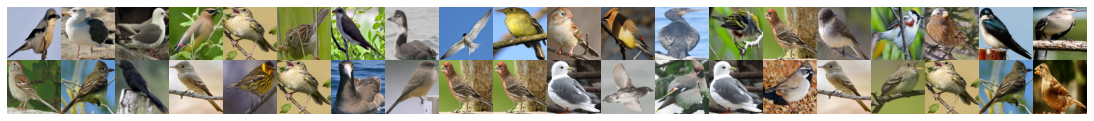

In [49]:
ncols = min(len(imgs_h), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(imgs, imgs_h)):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.permute(1, 2, 0))
        # ax[j, i].set_xticks([])
        # ax[j, i].set_yticks([])
        ax[j, i].set_axis_off()
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
fig.savefig(os.path.join(PATH, 'CUBImgX_Txt2Img.pdf'), dpi=300)

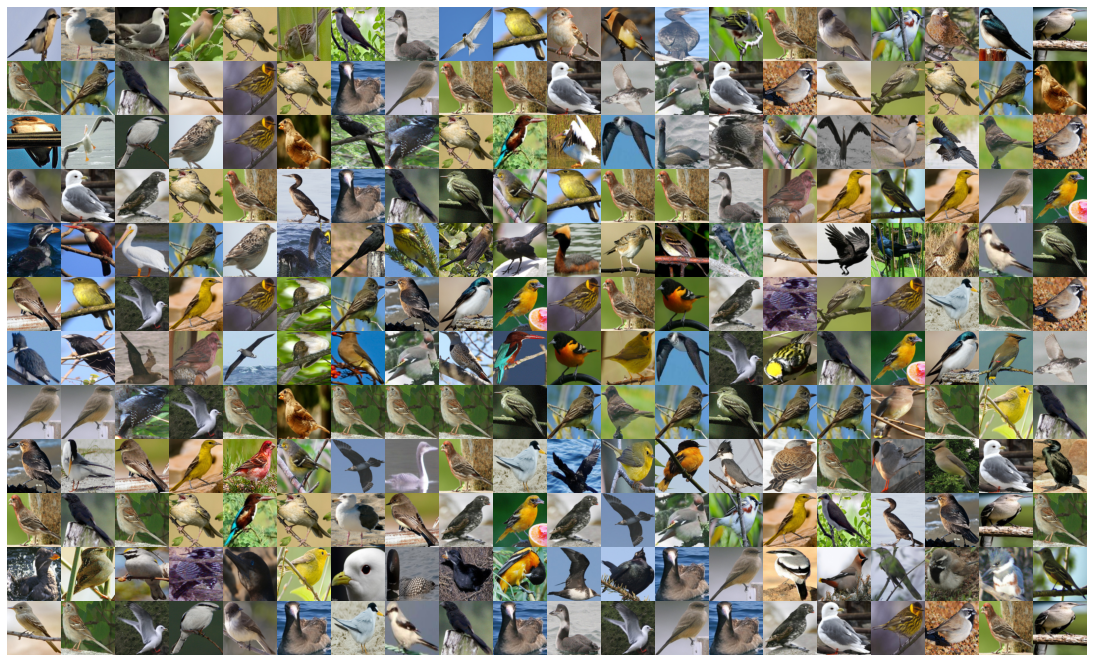

In [50]:
ncols = min(len(imgs_h), 20)
nrows = 2 * int(np.floor(len(imgs_h) / 20))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 1.5*nrows/2))
for i, aux in enumerate(zip(imgs, imgs_h)):
    if i >= nrows / 2 * 20:
        break
    for j, im in enumerate(aux):
        ax[j+i//20*2, i%20].imshow(im.permute(1, 2, 0))
        # ax[j+i//20*2, i%20].set_xticks([])
        # ax[j+i//20*2, i%20].set_yticks([])
        ax[j+i//20*2, i%20].set_axis_off()
    ax[1+i//20*2, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
fig.savefig(os.path.join(PATH, 'CUBImgX_Txt2ImgExtra.pdf'), dpi=300)

In [51]:
sents_h = []
sents_emb = x_rec[1]
for sent_emb in sents_emb:
    sent_h = []
    for j in sent_emb:
        char = CUB_test.CUBtxt.i2w[str(int(j.item()))]
        if char == '<eos>':
            break
        sent_h.append(char)
    sents_h.append(' '.join(sent_h))

sents = []
for i, sent_h in enumerate(sents_h):
    sent = []
    for char in txts[i]['tok']:
        if char == '<eos>':
            break
        sent.append(char)
    sents.append(' '.join(sent))

In [52]:
for sent, sent_h in zip(sents, sents_h):
    print('     ', sent)
    print('Rec: ', sent_h)

      a small bird with with grey crown and white breast and side and the black primaries .
Rec:  a small bird with a brown crown and brown head and belly , and and wings .
      a medium sized bird with white and black feathers , a large bill with pink feet and tarsus .
Rec:  a small bird bird with black and white wings , a black bill , and tarsus and feet .
      a large bird with a white body , and gray wings , and a smooth round crown .
Rec:  a small bird with a black and , breast and belly and and a , black bill .
      this bird has wings that are black and has a white belly .
Rec:  this bird has wings that are black and has a white belly .
      this bird has a black crown as well as a white belly .
Rec:  this bird has a black crown as well as a white belly .
      this bird has wings that are brown and has a white body .
Rec:  this bird has wings that are black and has a yellow belly .
      the bird has a bill that is small and yellow and black .
Rec:  this bird has a wings th

In [53]:
with open(os.path.join(PATH, 'CUBTxtX_Txt2Img.txt'), 'w') as file:
    for sent, sent_h in zip(sents, sents_h):
        file.write('Ref: ' + sent + '\n')
        file.write('Rec: ' + sent_h + '\n')

### Joint Generation

In [54]:
with torch.no_grad():
    for i, (img, txt, idx) in enumerate(test_loader):
        results = vae([None, None])
        x_rec = results['x_rec']
        x_rec = [x_rec[0].loc, x_rec[1].probs.argmax(dim=1).reshape(x_rec[0].loc.shape[0], -1)]
        dist, idx_h = NN_lookup(x_rec[0], img)
        # dist, idx_h = NN_lookup(results['x_rec'][0], img)
        imgs_h = [CUB_test.CUBimg.dataset[int(idx[j]) // 10][0] for j in idx_h]
        imgs = [CUB_test.CUBimg.dataset[int(j) // 10][0] for j in idx]
        txts = [CUB_test.CUBtxt.data[str(int(j))] for j in idx]
        break

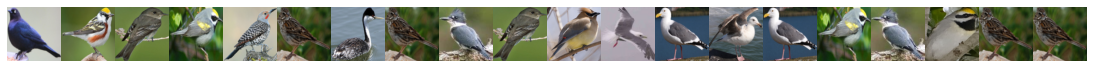

In [55]:
ncols = min(len(imgs_h), 20)
fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(15, 1))
for i, im in enumerate(imgs_h):
    if i >= ncols:
        break
    ax[i].imshow(im.permute(1, 2, 0))
    # ax[i].set_xticks([])
    # ax[i].set_yticks([])
    ax[i].set_axis_off()
fig.tight_layout(pad=0)
fig.savefig(os.path.join(PATH, 'CUBImgJointGen.pdf'), dpi=300)

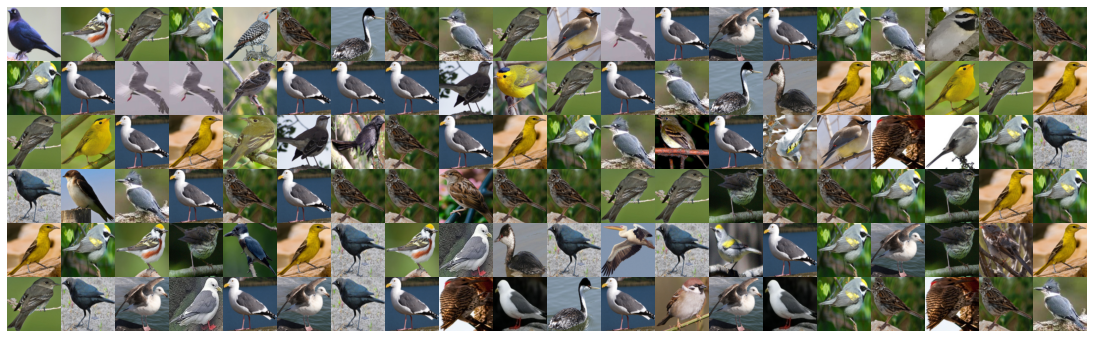

In [56]:
ncols = min(len(imgs_h), 20)
nrows = int(np.floor(len(imgs_h) / 20))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 0.75*nrows))
ax = ax.flatten()
for i, im in enumerate(imgs_h):
    if i >= nrows * 20:
        break
    ax[i].imshow(im.permute(1, 2, 0))
    # ax[i].set_xticks([])
    # ax[i].set_yticks([])
    ax[i].set_axis_off()
fig.tight_layout(pad=0)
fig.savefig(os.path.join(PATH, 'CUBImgJointGenExtra.pdf'), dpi=300)

In [57]:
sents_h = []
sents_emb = x_rec[1]
for sent_emb in sents_emb:
    sent_h = []
    for j in sent_emb:
        char = CUB_test.CUBtxt.i2w[str(int(j.item()))]
        if char == '<eos>':
            break
        sent_h.append(char)
    sents_h.append(' '.join(sent_h))

In [58]:
for sent_h in sents_h:
    print(sent_h)

this bird has a white belly , black wings , and a light brown , and a a short and bill .
this bird has a red overall and color on the feathers .
this bird is black with white and and has very short bill .
this bird has a long breast , and a long beak .
this small bird has a brown speckled , with a a brown , , a white , , and a black black bill .
this bird has a pointed bill , with a a brown belly .
this brown and white bird is black and the a and orange , and and and brown .
this is and white bird with a long belly and a pointed beak .
this bird is mostly and with a long white beak and black feet .
a brown and white and bird with a yellow beak .
this bird is mostly white in color , with a black , and and a a pointy bill .
a large bird with a white bill , white breast , and black white . .
a medium sized black bird with a bright white head , a black , and and black . .
this large bird has a white body , white neck and a black bill .
this bird has a white , white wings and breast , white

In [59]:
with open(os.path.join(PATH, 'CUBTxtJointGen.txt'), 'w') as file:
    for sent_h in sents_h:
        file.write(sent_h + '\n')